# Anomaly detection using a global normalization

In [1]:
using CABLAB

In this example we combine the subsample-quantile approach with the extreme event detection methods. We first take some sample grid cells out of the cube, calculate the 40% and 60% quantile to normalize the variables against each other. We also use this subsample to train the optimization parameters used for the extreme event detectioon methods. 

In [2]:
c=Cube("/Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res/")
cdata=getCubeData(c,variable=c.dataset_files,longitude=(-10,35),latitude=(30,65)
                    ,variable=["air_temperature_2m","Rg","fpar_fluxcom"])
cdata_filled=mapCube(gapFillMSC,cdata)
cdata_anom=mapCube(removeMSC,cdata_filled);

In [3]:
sp=sampleLandPoints(cdata,3000)
spfilled=mapCube(gapFillMSC,sp)
spanom=mapCube(removeMSC,spfilled)

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Spatial points axis with 3000 points
Variable            Axis with elements: air_temperature_2m Rg fpar_fluxcom 


In [4]:
spquants = mapCube(CABLAB.Proc.Stats.timespacequantiles,readCubeData(spanom),[0.4,0.6])
spquants.data

2×3 Array{Float32,2}:
 -0.545855  -0.218859  -0.00587172
  0.547502   0.376695   0.0112215 

In [5]:
function scaleCubeQuantiles(xout::AbstractVector,xin::AbstractVector,quantiles)
    absm=(abs(quantiles[1])+abs(quantiles[2]))/2
    for i in eachindex(xin)
        xout[i]=xin[i]/absm
    end
end
registerDATFunction(scaleCubeQuantiles,((TimeAxis,),(QuantileAxis,)),(TimeAxis,),inmissing=(:nan,:nan),outmissing=:nan,no_ocean=1);

The we normalize the cube by dividing each value by the absmean of the 40% and 60% quantile.

In [6]:
cdata_norm=mapCube(scaleCubeQuantiles,(cdata_anom,spquants))

Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25
Variable            Axis with elements: air_temperature_2m Rg fpar_fluxcom 


In [7]:
using StatsBase
function getTrainArray(smallcube)
    dmem=readCubeData(smallcube).data;
    sampletimes=rand(1:506,5000)
    sampleplaces=rand(1:2000,5000)
    trainarray=Float64[dmem[sampletimes[i],sampleplaces[i],j] for i=1:5000,j=1:3]
    nnans=squeeze(mapreducedim(isnan,+,trainarray,2),2)
    trainarray=trainarray[nnans.==0,:];
    trainarray
end
trainarray=getTrainArray(spanom);

In [8]:
addprocs(10);

In [9]:
CABLAB.DAT.init_DATworkers();

In [10]:
@time xout2=mapCube(DAT_detectAnomalies!,cdata_norm,["REC", "KDE", "KNN_Gamma"],trainarray)

146.647744 seconds (11.39 M allocations: 737.999 MB, 0.91% gc time)


Temporary Data Cube with the following dimensions
Time                Axis with 506 Elements from 2001-01-01T00:00:00 to 2011-12-27T00:00:00
Method              Axis with elements: REC KDE KNN_Gamma 
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 140 Elements from 65.0 to 30.25


In [11]:
rmprocs(workers())

:ok

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 0.50 
 0.75 
 1.00
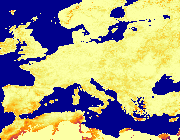

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 0.2 
 0.4 
 0.6
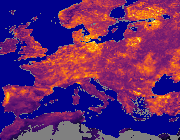

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 10 
 20 
 30
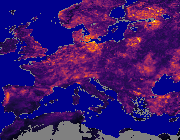

In [15]:
display(plotMAP(xout2,time=160,method=1))
display(plotMAP(xout2,time=160,method=2))
display(plotMAP(xout2,time=160,method=3))

In [13]:
meanscore=reduceCube(mean, xout2, TimeAxis, no_ocean=true);

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0
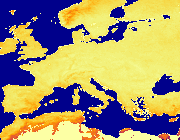

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 
 
 0.2 
 0.3 
 0.4 
 0.5
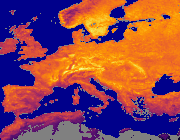

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 5 
 10
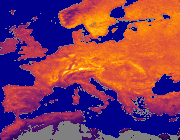

In [14]:
display(plotMAP(meanscore,method=1))
display(plotMAP(meanscore,method=2))
display(plotMAP(meanscore,method=3))

For all methods one can observe the effect of the global normalization. This leads to an overdetection of extremes in the zones where variablility of the underlying variables is highest. 